# Birthday Weather
## Written By Jared Rennie (@jjrennie)

Get weather information from the day you were born, using data procured and archived by multiple sources, including 
- <a href="https://www.ncei.noaa.gov/" target="_blank">NOAA's National Centers For Environmental Information (NCEI)</a>
- <a href="https://www.wpc.ncep.noaa.gov/" target="_blank">NOAA's Weather Prediction Center (WPC)</a>
- <a href="https://www.nhc.noaa.gov/" target="_blank">NOAA's National Hurricane Center (NHC)</a>
- <a href="https://ncar.ucar.edu/" target="_blank">NSF's National Center for Atmospheric Research (NCAR)</a>
- <a href="https://www.ecmwf.int/" target="_blank">The European Centre for Medium-Range Weather Forecasts (ECMWF)</a>
- <a href="https://www.drought.gov/" target="_blank">National Integrated Drought Information System (NIDIS)</a>
- <a href="https://www.nohrsc.noaa.gov/nsa/" target="_blank">NOAA's National Operational Hydrologic Remote Sensing Center (NOHRSC)</a>
- <a href="https://mesonet.agron.iastate.edu/" target="_blank">Iowa Environmental Mesonet </a>

Most of the data used in this notebook is hosted by cloud repositories such as <a href="https://aws.amazon.com/" target="_blank">Amazon Web Services</a> and <a href="https://cloud.google.com/" target="_blank"> Google Cloud</a>. For this notebook we will use Python packages that utilize AWS. 

## Table of Contents:
### Starting off (Required before other parts of notebook work)
* [Importing Packages](#first-bullet)
* [Insert User Arguments](#second-bullet)

### General Birthday Wx Examples
* [Birthday Wx: Weather Station Information (Day of Birth)](#third-bullet)
* [Birthday Wx: Weather Station Information (Year of Birth)](#fourth-bullet)
* [Birthday Wx: Daily Maximum Temperature Across the US](#fifth-bullet)
* [Birthday Wx: Daily Precipitation Accumulation Across the US](#sixth-bullet)
* [Birthday Wx: Surface Analysis, Incluing Sea Level Pressure and High/Lows](#seventh-bullet)
* [Birthday Wx: Tropical Cyclones](#trop-bullet)

### Bonus Birthday Wx Examples
* [BONUS: Upper Atmosphere Winds (Approximately 30,000 feet)](#eighth-bullet)
* [BONUS: Drought Monitor (2000-Present)](#ninth-bullet)
* [BONUS: Snowfall Analysis (2009-Present)](#tenth-bullet)
* [BONUS: Storm Reports (Hail, Wind, Tornadoes, 1950-Present)](#eleventh-bullet)

## Importing Packages <a class="anchor" id="first-bullet"></a>
First import all the python packages we need. The "easiest" way is to install these is by installing <a href="https://www.anaconda.com/" target="_blank">Anaconda</a>, and then applying <a href="https://conda-forge.org/" target="_blank">conda-forge</a>. Afterward, then you can install the above packages.

In [1]:
# Import packages
%matplotlib inline

import json,requests,sys,calendar,math,s3fs,pytz,os
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma

from datetime import datetime, date, timedelta
from calendar import monthrange
from timezonefinder import TimezoneFinder
from scipy.ndimage import gaussian_filter
from geopy.geocoders import Nominatim

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import metpy.calc as mpcalc
from metpy.units import units
from metpy.calc import find_peaks
from metpy.plots import scattertext
import tropycal.tracks as tracks

import warnings
warnings.filterwarnings("ignore")

print("SUCCESS!")

SUCCESS!


If you made it this far, great!

## Insert User Arguments <a class="anchor" id="second-bullet"></a>
**Change the arguments below to your liking**
- What day were you born?
- Where you were born?
- What is your name? (So you can get the credit!)

In [2]:
# Insert Arguments Here
inYear=2011
inMonth=4
inDay=27
inCity="Tuscaloosa"
inState='AL'
author='Not Jared Rennie'

Here are some other arguments that will help with plotting later. ***No need to change*** unless you feel comfortable

In [3]:
# Other Arguments
dpi=100
minLat = 22 ; maxLat = 50 ; minLon = -120; maxLon = -73 # Set CONUS Bounds
ocean_hex = '#ececeb'
land_hex = '#d2d6d6'
edgecolor= 'black'

### Find a Weather Station Near Your Birth Location 
Run the code block below to get 10 stations near your location of birth, which you put above.

In [4]:
%%time
# Get Metadata from NCEI Website
ghcnh_meta_url='https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/doc/ghcnh-station-list.csv'

# Pull Data into Pandas DataFrame
try:
  ghcnhMeta = pd.read_csv(ghcnh_meta_url)
except Exception as e:
  print('SOMETHING WENT WRONG: ',e)
ghcnhMeta=ghcnhMeta.sort_values(by='NAME')

"""
Find the 10 nearest GHCN stations to a given U.S. city/state
using NOAA's official GHCN metadata file and geopy for geocoding.
"""
# --- Helper: Haversine distance (km) ---
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, phi2 = map(math.radians, [lat1, lat2])
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2) ** 2
    return 2 * R * math.asin(math.sqrt(a))

# --- Step 1: Geocode the city/state ---
def geocode_city_state(city: str, state: str):
    geolocator = Nominatim(user_agent="ghcn-nearest-stations-script")
    loc = geolocator.geocode(f"{city}, {state}, USA")
    if not loc:
        raise ValueError(f"Could not geocode location: {city}, {state}")
    return loc.latitude, loc.longitude

# --- Step 2: Load GHCN-H station metadata ---
def load_ghcnh_stations(url: str = ghcnh_meta_url):
    df = pd.read_csv(url)
    df.columns = df.columns.str.strip()
    if not {"GHCN_ID", "LATITUDE", "LONGITUDE"}.issubset(df.columns):
        raise ValueError(f"Unexpected CSV format. Columns: {df.columns.tolist()}")
    df = df.rename(columns={"LATITUDE": "lat", "LONGITUDE": "lon"})
    df = df.dropna(subset=["lat", "lon"])
    return df

# --- Step 3: Find nearest N stations ---
def find_nearest_stations(city: str, state: str, n: int = 10):
    user_lat, user_lon = geocode_city_state(city, state)
    df = load_ghcnh_stations()

    # ✅ Filter to only include stations starting with 'USW'
    df = df[df["GHCN_ID"].astype(str).str.startswith("USW")].copy()
    
    df["distance_km"] = df.apply(lambda r: haversine(user_lat, user_lon, r["lat"], r["lon"]), axis=1)
    nearest = df.sort_values("distance_km").head(n)
    print(f"\nNearest {n} stations to {city}, {state} (lat={user_lat:.3f}, lon={user_lon:.3f})\n")
    print(nearest[["GHCN_ID", "NAME", "lat", "lon", "distance_km"]].to_string(index=False, float_format="%.2f"))

# Run Function, results below
try:
    find_nearest_stations(inCity, inState)
except:
    print('ERROR: Issue Getting information for your location: ',inCity,', ',inState)


Nearest 10 stations to Tuscaloosa, AL (lat=33.210, lon=-87.568)

    GHCN_ID                        NAME   lat    lon  distance_km
USW00073801               NORTHPORT 2 S 33.21 -87.59         2.24
USW00093806          TUSCALOOSA AP ASOS 33.21 -87.62         4.48
USW00003881            CENTREVILLE WSMO 32.90 -87.25        45.39
USW00063893            GREENSBORO 2 WNW 32.72 -87.62        55.02
USW00063892            GAINESVILLE 2 NE 32.84 -88.14        67.39
USW00053864 ALABASTER SHELBY CO AP ASOS 33.18 -86.78        73.20
USW00093869                  BIRMINGHAM 33.53 -86.83        77.10
USW00000156     WALKER CO AP BEVILL FLD 33.90 -87.31        80.49
USW00013876               BIRMINGHAM AP 33.57 -86.75        86.02
USW00063858                SELMA 13 WNW 32.46 -87.24        89.06
CPU times: user 157 ms, sys: 11.3 ms, total: 169 ms
Wall time: 949 ms


Pick a station from one of the 10 options above., use the 11 digit 'GHCN_ID' to make your selection.<a class="anchor" id="station-change"></a>

***NOTE If you get any type of errors below, you may have to select another station from the list above, or pick a different city and state combination.***

In [5]:
# Pick a station from 'GHCN_ID'
# If you get errors for this station you may have to return to this block of code and pick a different station.
inSTN='USW00093806'

First, let's get some metadata information about the station selected. We will need these when plotting later.

In [6]:
# Grab Metadata
stnMeta=ghcnhMeta[ghcnhMeta['GHCN_ID']==inSTN]

stnGHCN=stnMeta['GHCN_ID'].values[0]
stnICAO=stnMeta['ICAO'].values[0]
stnLat=stnMeta['LATITUDE'].values[0]
stnLon=stnMeta['LONGITUDE'].values[0]
stnElev=stnMeta['ELEVATION'].values[0]
stnState=stnMeta['STATE'].values[0]
stnName=stnMeta['NAME'].values[0].title()

stnMeta

,GHCN_ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN,(US)HCN_(US)CRN,WMO_ID,ICAO
33315,USW00093806,33.2122,-87.6156,45.1,AL,TUSCALOOSA AP ASOS,NaN,NaN,NaN,KTCL


Ok, now let's have some fun!
## Birthday Wx: Weather Station Information (Day of Birth) <a class="anchor" id="third-bullet"></a>
Here we will aquire weather information that occured over the day you were born, including temerature, dew point, rainfall, and cloud cover. This particular section uses data from the <a href="https://www.ncei.noaa.gov/products/global-historical-climatology-network-hourly" target ="_blank">Global Historical Climatological Network</a>, hosted by <a href="https://www.ncei.noaa.gov/" target ="_blank">NOAA's National Centers for Environmental Information</a>.

In [7]:
# DEFINE URL (parquet data hosted by NCEI)
ghcnh_url = 'https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/access/by-year/'+str(inYear)+'/parquet/GHCNh_'+str(inSTN)+'_'+str(inYear)+'.parquet'
print(ghcnh_url)

# Pull Data into Pandas DataFrame
try:
  ghcnhPandas = pd.read_parquet(ghcnh_url)
  print('SUCCESS')
except Exception as e:
  print('SOMETHING WENT WRONG: ',e)
  print('\tMay need to pick another station')

https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/access/by-year/2011/parquet/GHCNh_USW00093806_2011.parquet
SUCCESS


- If it says **"SUCCESS"**, then great! You got the data. 
- If you get **"SOMETHING WENT WRONG"** the data may not exist for this particular station, [RETURN ABOVE](#station-change) and pick a different station or city.

Now we need to subset to only get the data we need, this block of code will do that for you.

In [8]:
%%time

#Get a subset of Data based on User inputs
subsetCols=['DATE','temperature','dew_point_temperature','precipitation','sky_cover_1']
subsetPandas = ghcnhPandas[subsetCols].copy()

# Create Date in UTC and Local 
subsetPandas['DATE_UTC'] = pd.to_datetime(subsetPandas['DATE'], utc=True)

# Use stnLat and stnLon to find the timezone
tf = TimezoneFinder()
zone_result = tf.timezone_at(lat=stnLat, lng=stnLon)

if zone_result:
    local_tz = pytz.timezone(zone_result)
    # Convert UTC to local time
    subsetPandas['DATE_LOCAL'] = subsetPandas['DATE_UTC'].dt.tz_convert(local_tz)
else:
    print("Timezone could not be determined for the provided coordinates.")
    subsetPandas['DATE_LOCAL'] = None
subsetPandas.drop(columns=['DATE','DATE_UTC'], inplace=True)

inDate= "%04i-%02i-%02i" % (inYear,inMonth,inDay)

filtered_df = subsetPandas[pd.to_datetime(subsetPandas['DATE_LOCAL'], errors='coerce').dt.date == pd.to_datetime(inDate).date()].reset_index()
filtered_df['temperature']=(filtered_df['temperature']* 1.8) + 32.
filtered_df['dew_point_temperature']=(filtered_df['dew_point_temperature']* 1.8) + 32.
filtered_df['precipitation']=(filtered_df['precipitation']* 0.0393701)

temp_max= "%.1f°F" % (np.max(filtered_df['temperature']))
temp_min= "%.1f°F" % (np.min(filtered_df['temperature']))
dewp_max= "%.1f°F" % (np.max(filtered_df['dew_point_temperature']))
dewp_min= "%.1f°F" % (np.min(filtered_df['dew_point_temperature']))

#Check Precip Info
filtered_df_rain=filtered_df[filtered_df['precipitation'].notna() & (filtered_df['precipitation']  > 0)]

# Define bins and labels
bins = [0.009, 0.05, 0.10, 0.25, float('inf')]
labels = ['0.01–0.05', '0.05–0.10', '0.10–0.25', '>0.25']
color_map = {
    '0.01–0.05': '#edf8e9',
    '0.05–0.10': '#bae4b3',
    '0.10–0.25': '#74c476',
    '>0.25': '#238b45'
}

# Bin the values and map to colors
filtered_df_rain['precip_bin'] = pd.cut(filtered_df_rain['precipitation'], bins=bins, labels=labels)
filtered_df_rain['precip_color'] = filtered_df_rain['precip_bin'].map(color_map)

#Check Cloud Info
filtered_df_cloud=filtered_df[filtered_df['sky_cover_1'].notna() & (filtered_df['sky_cover_1'] != 'None')]

# Define the color mapping
color_map = {
    'OVC': '#252525',
    'BKN': '#636363',
    'SCT': '#969696',
    'FEW': '#cccccc',
    'CLR': '#f7f7f7'
}

# Extract the prefix and map to color
filtered_df_cloud['cloud_color'] = filtered_df_cloud['sky_cover_1'].str[:3].map(color_map)
filtered_df

CPU times: user 515 ms, sys: 8.43 ms, total: 523 ms
Wall time: 523 ms


,index,temperature,dew_point_temperature,precipitation,sky_cover_1,DATE_LOCAL
0,3776,75.02,66.02,0.000000,BKN:07,2011-04-27 00:53:00-05:00
1,3777,75.20,66.20,NaN,SCT:04,2011-04-27 01:25:00-05:00
2,3778,75.20,66.20,NaN,SCT:04,2011-04-27 01:32:00-05:00
3,3779,75.02,66.02,0.000000,BKN:07,2011-04-27 01:53:00-05:00
4,3780,75.20,66.20,NaN,SCT:04,2011-04-27 02:42:00-05:00
...,...,...,...,...,...,...
56,3832,69.80,62.60,0.200788,FEW:02,2011-04-27 21:13:00-05:00
57,3833,69.80,62.60,0.200788,FEW:02,2011-04-27 21:15:00-05:00
58,3834,69.08,59.00,0.200788,BKN:07,2011-04-27 21:53:00-05:00
59,3835,68.00,53.06,0.000000,OVC:08,2011-04-27 22:53:00-05:00


You should see a dataframe with some variables. This is the weather information for the day you were born! Great, but let's visualize it!

PLOTTING


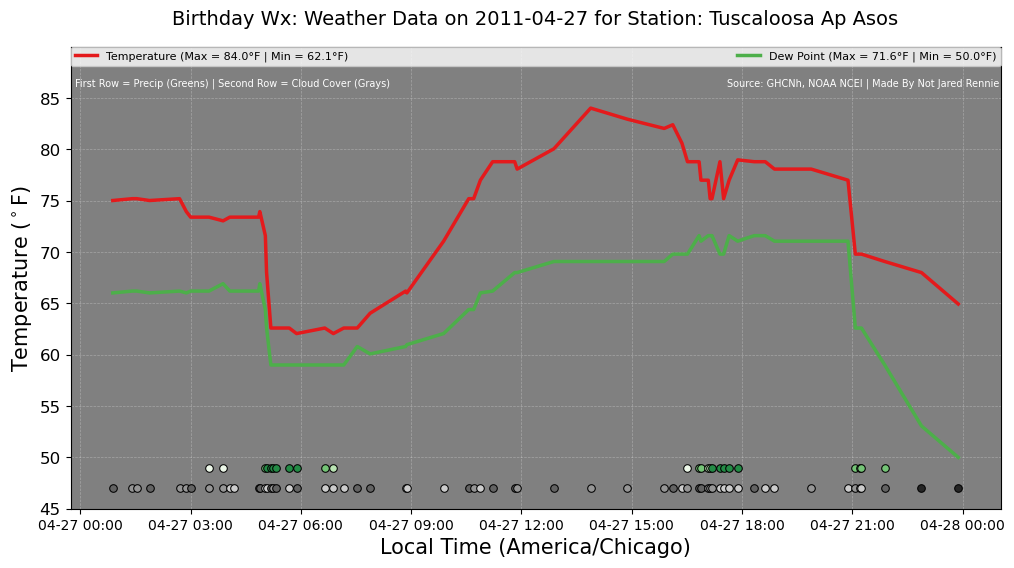

CPU times: user 632 ms, sys: 119 ms, total: 751 ms
Wall time: 647 ms


In [9]:
%%time

############################################################
# PLOT
print("PLOTTING")

fig, axf = plt.subplots(figsize=(12, 6), edgecolor='white', facecolor='white', dpi=dpi)

# Add grid lines
plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
axf.set_facecolor('#808080')

# Plot Data
plt.plot(filtered_df['DATE_LOCAL'], filtered_df['temperature'], linewidth=2.5, color='#e41a1c', label="Temperature (Max = "+temp_max+" | Min = "+temp_min+")")
plt.plot(filtered_df['DATE_LOCAL'], filtered_df['dew_point_temperature'], linewidth=2.5, color='#4daf4a', label="Dew Point (Max = "+dewp_max+" | Min = "+dewp_min+")")

# Plot Y Limits
ymin=min(int(5 * round(float((min(filtered_df['dew_point_temperature']) - 5))/5)),9999)
ymax=max(int(5 * round(float((max(filtered_df['temperature']) + 5))/5)),-9999)
plt.ylim(ymin, ymax)

# Plot Precip Info (If Available)
for index, row in filtered_df_rain.iterrows():
  if pd.notna(row['precip_color']):
      plt.scatter(row['DATE_LOCAL'],ymin+4,zorder=10, s=30, color=row['precip_color'], alpha=1, edgecolor='black', linewidth=0.75)

# Plot Cloud Info (If Available)
for index, row in filtered_df_cloud.iterrows():
  if pd.notna(row['cloud_color']):
      plt.scatter(row['DATE_LOCAL'],ymin+2,zorder=10, s=30, color=row['cloud_color'], alpha=1, edgecolor='black', linewidth=0.75)

# Plot Legend
plt.legend(loc=9, ncol=2, mode="expand", borderaxespad=0., fontsize=8)

# Plot Y-Axis Label
plt.yticks(range(ymin, ymax, 5), [r'{}'.format(x) for x in range(ymin, ymax, 5)], fontsize=12, color='black')
plt.ylabel(r'Temperature ($^\circ$F)', fontsize=15, color='black')

# Plot X-Axis Label
plt.xlabel(r'Local Time ('+zone_result+')', fontsize=15, color='black')
plt.xticks(color='black')
axf.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M', tz=filtered_df['DATE_LOCAL'].dt.tz))

# Plot Title/Subtitle
plt.title('Birthday Wx: Weather Data on '+str(inDate)+' for Station: '+str(stnName), fontsize=14, color='black',y=1.03)
plt.annotate('Source: GHCNh, NOAA NCEI'+' | Made By '+author,xy=(0.999, 0.91), xycoords='axes fraction', fontsize=7,horizontalalignment='right', verticalalignment='bottom', color='white')
plt.annotate('First Row = Precip (Greens) | Second Row = Cloud Cover (Grays)',xy=(0.005, 0.91), xycoords='axes fraction', fontsize=7,horizontalalignment='left', verticalalignment='bottom',color='white')

# Remove some variables (to save memory)
del ghcnhPandas, subsetPandas, filtered_df, filtered_df_rain, filtered_df_cloud

# Show Figure
plt.show()

If a plot shows up, and there is enough data, you can get a sense of
- How hot/cold (or even humid/dry) it was that day.
- What the max / min temperature was.
- Did it rain? (green circles on the bottom of the graph indicate if rain fell)
- How cloudy it was (gray circles, the darker it is, the cloudier it was)

If you have an issue plotting, or don't have all the parameters, you may have to [RETURN ABOVE](#station-change) and pick a different station or city.

**CONGRATS!!!** Now you have some information from the day you were born. But what about the entire year?

## Birthday Wx: Weather Station Information (Year Of Birth) <a class="anchor" id="fourth-bullet"></a>
This block of code will get temperature information for the station, but for the entire year you were born.

Here we are grabbing daily data from the <a href="https://www.ncei.noaa.gov/products/global-historical-climatology-network-daily" target ="_blank">Global Historical Climatological Network</a> and are using a specific API from the <a href="https://www.rcc-acis.org/" target ="_blank">Applied Climate Information System (ACIS)</a>.

In [10]:
%%time

# Build JSON to access ACIS API (from https://www.rcc-acis.org/docs_webservices.html)
acis_url = 'http://data.rcc-acis.org/StnData'
payload = {
"output": "json",
"params": {"elems":[{"name":"maxt","interval":"dly","prec":1},
                    {"name":"mint","interval":"dly","prec":1},
                    {"name":"maxt","interval":"dly","normal":"1","prec":1},
                    {"name":"mint","interval":"dly","normal":"1","prec":1}],
           "sid":inSTN,
           "sdate":"por",
           "edate":"por"
          } 
}

# Make Request
try:
    r = requests.post(acis_url, json=payload,timeout=3)
    acisData = r.json()
except Exception as e:
    print('SOMETHING WENT WRONG: ',e)
    print('\tMay need to pick another station')

# Get Station Info
stationName=acisData['meta']['name'].title()
stationState=acisData['meta']['state']

# Convert data into Pandas DataFrame
acisPandas = pd.DataFrame(acisData['data'], columns=['Date','TmaxVal','TminVal','TmaxNormal','TminNormal'])

print("\nSuccessfully Orgainzed Data for: ",stationName,',',stationState)
print(acisPandas)

stationStart=acisPandas.iloc[[0]]['Date'].values[0][0:4]
stationEnd=acisPandas.iloc[[-1]]['Date'].values[0][0:4]
print("Period of Record: ",stationStart,"-",stationEnd)

# Remove Missing Data And Reformat Each Column
for (columnName, columnData) in acisPandas.items():
    acisPandas = acisPandas[acisPandas[columnName] != 'M']
    if columnName == 'Date':
        acisPandas[columnName] = pd.to_datetime(acisPandas[columnName])
    else:
        acisPandas[columnName] = pd.to_numeric(acisPandas[columnName])
lastDate=acisPandas.iloc[-1]['Date']

# Get Extremes of Tmax/Tmin for each day
acisPandas['Year'] = acisPandas['Date'].dt.year
acisPandas['DayOfYear'] = acisPandas['Date'].dt.dayofyear
acisExtremes1 = acisPandas.groupby(['DayOfYear']).agg({'TmaxVal': 'max', 'TminVal': 'min'}).reset_index()
acisExtremes2 = acisPandas.groupby(['DayOfYear']).agg({'TmaxVal': 'min', 'TminVal': 'max'}).reset_index()

# Get Data for Year Given as Input, and take care of leap day.
# Also need a full year for plotting other data, so use a complete year (ie 2020)
normalData=acisPandas[acisPandas['Year']==2016]

if not calendar.isleap(inYear):
    acisExtremes1=acisExtremes1.drop(acisExtremes1[acisExtremes1['DayOfYear'] == 60].index).reset_index(drop=True)
    #acisExtremes1['DayOfYear'] = range(1, 366)

    acisExtremes2=acisExtremes2.drop(acisExtremes2[acisExtremes2['DayOfYear'] == 60].index).reset_index(drop=True)
    #acisExtremes2['DayOfYear'] = range(1, 366)

    normalData=normalData.drop(normalData[normalData['DayOfYear'] == 60].index).reset_index(drop=True)
    #normalData['DayOfYear'] = range(1, 366)
    
# Find Days in the plot year that either tied or broke a record.
plotData=acisPandas[acisPandas['Year']==inYear].reset_index(drop=True)
highMax = plotData[plotData['TmaxVal'] >= acisExtremes1[0:len(plotData)]['TmaxVal']]
lowMin = plotData[plotData['TminVal'] <= acisExtremes1[0:len(plotData)]['TminVal']]
lowMax = plotData[plotData['TmaxVal'] <= acisExtremes2[0:len(plotData)]['TmaxVal']]
highMin = plotData[plotData['TminVal'] >= acisExtremes2[0:len(plotData)]['TminVal']]

print("SUCCESS")


Successfully Orgainzed Data for:  Tuscaloosa Arpt Asos , AL
             Date TmaxVal TminVal TmaxNormal TminNormal
0      1948-06-01    85.0    61.0       86.9       66.0
1      1948-06-02    87.0    54.0       87.1       66.2
2      1948-06-03    91.0    57.0       87.3       66.5
3      1948-06-04    93.0    57.0       87.5       66.7
4      1948-06-05    93.0    59.0       87.7       66.9
...           ...     ...     ...        ...        ...
28286  2025-11-10    44.0    26.0       67.3       43.9
28287  2025-11-11    55.0    24.0       66.9       43.6
28288  2025-11-12    74.0    35.0       66.6       43.4
28289  2025-11-13    75.0    44.0       66.3       43.1
28290  2025-11-14    76.0    42.0       65.9       42.8

[28291 rows x 5 columns]
Period of Record:  1948 - 2025
SUCCESS
CPU times: user 59.9 ms, sys: 12 ms, total: 71.9 ms
Wall time: 952 ms


If it says 'SUCCESS' now, you have some more information about this particular station, including
- Daily Max/Min Temperature
- What a 'typical' or 'normal' day is like for a given day, using the <a href="https://www.ncei.noaa.gov/products/land-based-station/us-climate-normals" target="_blank">1991-2020 Normals</a>
- The stations Period of Record.

If you have an issue getting the data, you may have to [RETURN ABOVE](#station-change) and pick a different station or city.

Now let's try and plot this information

PLOTTING


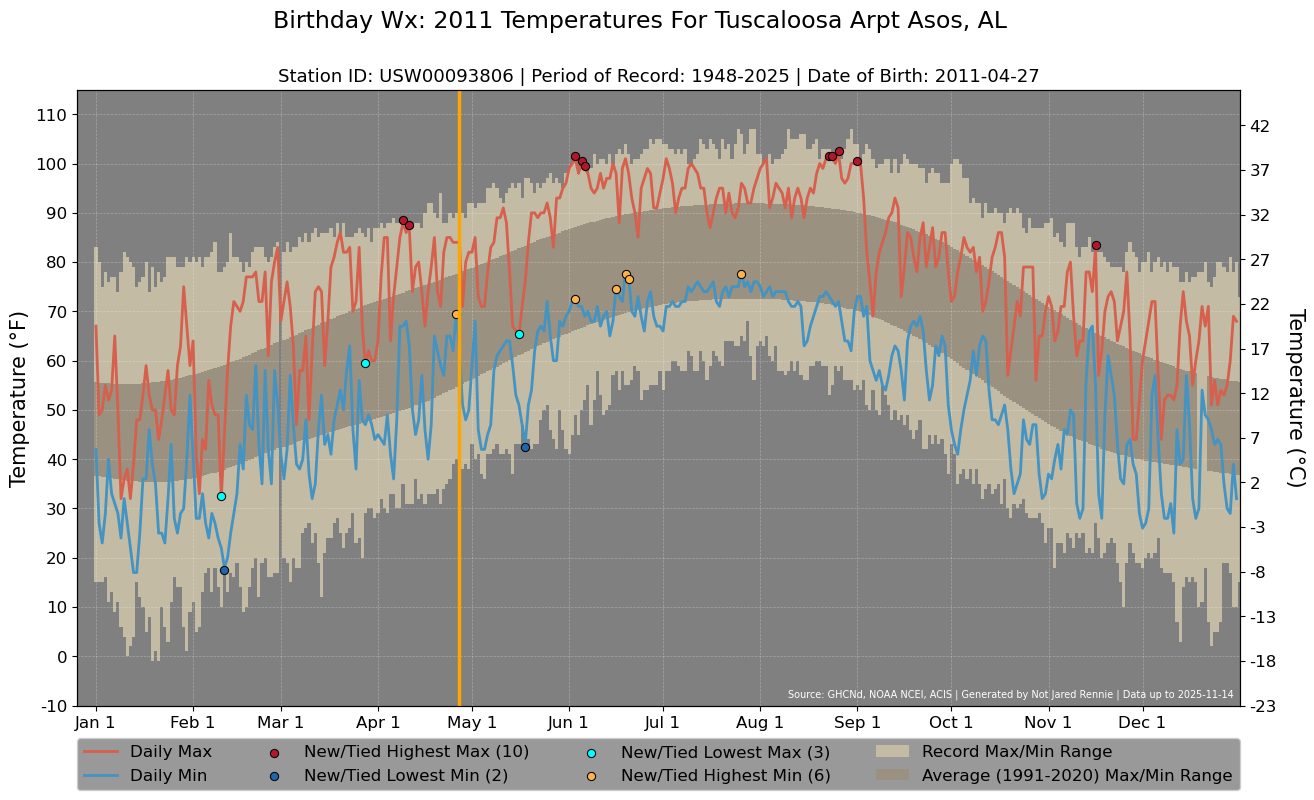

CPU times: user 870 ms, sys: 89.9 ms, total: 959 ms
Wall time: 847 ms


In [11]:
%%time

############################################################
# PLOT
print("PLOTTING")

outDate1 = datetime(inYear, inMonth, inDay).strftime("%Y-%m-%d")
outDate2 = datetime(inYear, inMonth, inDay).timetuple().tm_yday

# Set up the plot
fig, axf = plt.subplots(figsize=(15, 8), edgecolor='white', facecolor='white', dpi=dpi)

# Add grid lines
plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
axf.set_facecolor('#808080')

# Plot Record TMAX/TMIN
plt.bar(acisExtremes1['DayOfYear'], acisExtremes1['TmaxVal'] - acisExtremes1['TminVal'], bottom=acisExtremes1['TminVal'], edgecolor='none', color='#c3bba4', width=1, label="Record Max/Min Range")

# Plot Normal TMAX/TMIN
normals_start='1991';normals_end='2020'
plt.bar(normalData['DayOfYear'], normalData['TmaxNormal'] - normalData['TminNormal'], bottom=normalData['TminNormal'], edgecolor='none', color='#9a9180', width=1, label="Average ("+str(normals_start)+"-"+str(normals_end)+") Max/Min Range")

# Plot Raw TMAX/TMIN
plt.plot(plotData['DayOfYear'], plotData['TmaxVal'], linewidth=2, color='#D6604D', label="Daily Max")
plt.plot(plotData['DayOfYear'], plotData['TminVal'], linewidth=2, color='#4393C3', label="Daily Min")

# Plot New Max/Min Records
plt.scatter(highMax['DayOfYear'], highMax['TmaxVal'] + 0.50, s=35, zorder=10, color='#B2182B', alpha=1, edgecolor='black', linewidth=0.75, label="New/Tied Highest Max ("+str(len(highMax))+")")
plt.scatter(lowMin['DayOfYear'], lowMin['TminVal'] - 0.50, s=35, zorder=10, color='#2166AC', alpha=1, edgecolor='black', linewidth=0.75, label="New/Tied Lowest Min ("+str(len(lowMin))+")")
plt.scatter(lowMax['DayOfYear'], lowMax['TmaxVal'] + 0.50, s=35, zorder=10, color='cyan', alpha=1, edgecolor='black', linewidth=0.75, label="New/Tied Lowest Max ("+str(len(lowMax))+")")
plt.scatter(highMin['DayOfYear'], highMin['TminVal'] - 0.50, s=35, zorder=10, color='#FEB24C', alpha=1, edgecolor='black', linewidth=0.75, label="New/Tied Highest Min ("+str(len(highMin))+")")

# Plot Legend
plt.legend(bbox_to_anchor=(0., -.137, 1., -1.02), loc=3, ncol=4, mode="expand", borderaxespad=0., fontsize=12, facecolor='#808080')

# Set X/Y limits
ymin=int(5 * round(float((min(acisExtremes1['TminVal']) - 10))/5))
ymax=int(5 * round(float((max(acisExtremes1['TmaxVal']) + 10))/5))
plt.ylim(ymin, ymax)
plt.xlim(-5, 366) 

# Plot day you were born
plt.vlines(outDate2,ymin,ymax,colors='orange', linestyles='solid',linewidth=2.5,zorder=100)

# Plot X-Axis Labels/Ticks
month_pos=[1,32,60,91,121,152,182,213,244,274,305,335]
month_names=["Jan 1","Feb 1","Mar 1","Apr 1","May 1","Jun 1","Jul 1","Aug 1","Sep 1","Oct 1","Nov 1","Dec 1"]
plt.xticks(month_pos, month_names, fontsize=12, color='black')

# Plot Y-Axis Labels/Ticks (Left Side, degF)
plt.yticks(range(ymin, ymax, 10), [r'{}'.format(x) for x in range(ymin, ymax, 10)], fontsize=12, color='black')
plt.ylabel(r'Temperature (°F)', fontsize=15, color='black')

# Plot Y-Axis Labels/Ticks (Right Side, degC)
ymax=int((ymax-32) / 1.8)
ymin=int((ymin-32) / 1.8)
axc = axf.twinx()
y1, y2 = axf.get_ylim()
axc.set_ylim(int((y1-32) / 1.8), int((y2-32) / 1.8))
axc.figure.canvas.draw()
axf.callbacks.connect("ylim_changed", axc)
axc.set_ylabel(r'Temperature (°C)', fontsize=15, rotation=270, labelpad=20,color='black')
axc.set_yticks(range(ymin, ymax, 5), [r'{}'.format(x) for x in range(ymin, ymax, 5)], fontsize=12, color='black')

# Plot Title/Subtitle/Annotations
plt.suptitle("Birthday Wx: "+str(inYear)+' Temperatures For '+stationName+', '+stationState, fontsize=17,color='black')
plt.title('Station ID: '+stnGHCN+' | Period of Record: '+str(stationStart)+'-'+str(stationEnd)+' | Date of Birth: '+str(outDate1), fontsize=13,color='black')
plt.annotate('Source: GHCNd, NOAA NCEI, ACIS | Generated by '+author+' | Data up to '+lastDate.strftime('%Y-%m-%d'),xy=(0.995, 0.01), xycoords='axes fraction', fontsize=7,horizontalalignment='right', verticalalignment='bottom',color='white')

# Remove some variables (to save memory)
del acisPandas, acisData, r, acisExtremes1, acisExtremes2, normalData, plotData

# Show The Results!
plt.show()

Here we can see a great example of the "Weather Vs. Climate" trope.
- The smooth lines are what we expect (1991-2020 Normals, or "climate").
- The jagged lines (red and blue) are what we get (daily "weather").

The yearly values are also compared against the warmest/coldest day the station had on record, and if it tied or broke, it is indicated by a dot. The orange vertical line indicates your actual birthday.

Once again, if you have an issue plotting, or don't have all the parameters, you may have to [RETURN ABOVE](#station-change) and pick a different station or city.

## Birthday Wx: Daily Maximum Temperature Across the US <a class="anchor" id="fifth-bullet"></a>

So far we only have information for a specific location that is near your birth location, but what about the entire Continental US? This block will get gridded data for the US, using data from <a href="https://www.ncei.noaa.gov/products/land-based-station/nclimgrid-daily" target ="_blank">nClimGrid-Daily</a>, hosted by <a href="https://www.ncei.noaa.gov/" target ="_blank">NOAA's National Centers for Environmental Information</a>.

First let's read in the data, which is hosted on AWS.

In [12]:
%%time

#################################################
# READ IN DATA FROM AWS
day_counter=int(inDay)
current_date="%04i-%02i-%02i" % (int(inYear),int(inMonth),int(inDay))
current_month="%04i%02i" % (int(inYear),int(inMonth))

# Open File System
s3 = s3fs.S3FileSystem(anon=True)

# Get Specific File Based on Inputs
aws_year="%04i" % (int(inYear))
aws_month="%02i" % (int(inMonth))
aws_version='prelim'
aws_url='s3://noaa-nclimgrid-daily-pds/v1-0-0/grids/'+aws_year+'/ncdd-'+aws_year+aws_month+'-grd-'+aws_version+'.nc'

# Read in Data
print('READING IN nClimGrid DATA FROM AWS: ',aws_url)
try:
    aws_file=s3.open(aws_url)
except:
    aws_version='scaled'
    aws_url='s3://noaa-nclimgrid-daily-pds/v1-0-0/grids/'+aws_year+'/ncdd-'+aws_year+aws_month+'-grd-'+aws_version+'.nc'
    aws_file=s3.open(aws_url)

data_monthly = xr.open_dataset(aws_file)
print("SUCCESS!")

READING IN nClimGrid DATA FROM AWS:  s3://noaa-nclimgrid-daily-pds/v1-0-0/grids/2011/ncdd-201104-grd-prelim.nc
SUCCESS!
CPU times: user 202 ms, sys: 83.3 ms, total: 285 ms
Wall time: 1.58 s


If it says 'SUCCESS' great! You now got gridded climate data from AWS! The file includes 4 variables (max temperature, min temperature, average temperature, and precipitation). For this part, let's only read in the daytime maximum temperature.

In [13]:
# Get Element (options here are tmax/tmin/tavg)
element='tmax'

# Get Lat/Lons
nclimgrid_lats=data_monthly.lat.values
nclimgrid_lons=data_monthly.lon.values

# Get Data, Convert from metric
conus_value=(data_monthly[element].values[day_counter-1,:,:] * 1.8) + 32.
print("SUCCESS")

SUCCESS


Nothing else to do at this point but plot it!

PLOTTING


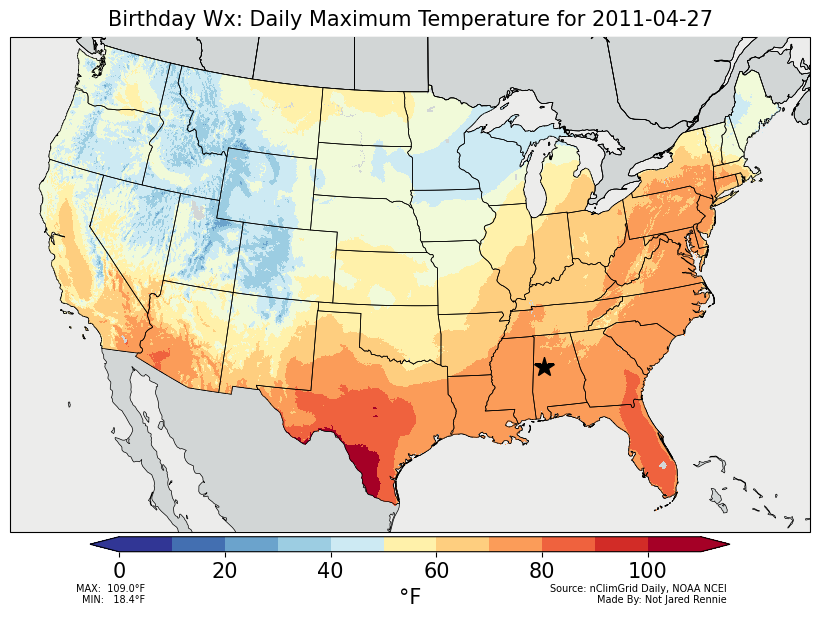

CPU times: user 2.49 s, sys: 120 ms, total: 2.61 s
Wall time: 2.49 s


In [14]:
%%time

#################################################
# PLOT
print("PLOTTING")

# Set up some other Plotting info
unit='°F'
element_name='Maximum Temperature'
colorMap='RdYlBu_r' 
bounds=np.array([0,10,20,30,40,50,60,70,80,90,100,110]) 

# Set Up Colorbar info
vmin=np.min(bounds)
vmax=np.max(bounds)
extend='both'
cmap = plt.get_cmap(colorMap, len(bounds))
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N, clip=True)
cm = plt.cm.ScalarMappable(cmap=cmap)
cm.set_array(np.array(conus_value))
cm.set_clim(vmin, vmax)

# Set Up Figure
fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.Geodetic())
ax.set_facecolor(ocean_hex)

# Add Boundaries
ax.add_feature(cfeature.LAND,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=3)
ax.add_feature(cfeature.LAKES,linewidth=0.5,facecolor=ocean_hex,edgecolor=edgecolor,zorder=4)
ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor=edgecolor,zorder=10)

# Plot Data
ax.pcolormesh(nclimgrid_lons, nclimgrid_lats, conus_value,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,zorder=9)

# Add Colorbar
cax = fig.add_axes([0.1, -0.035, 0.8, 0.03])
cbar=plt.colorbar(cm, cax=cax,boundaries=bounds,orientation='horizontal',extend=extend,spacing='uniform')
cbar.ax.tick_params(labelsize=15)
cbar.set_label(unit,size=15)

# Annotate Info On Graphic
nclimgrid_max="%6.1f" % np.nanmax(conus_value)
nclimgrid_min="%6.1f" % np.nanmin(conus_value)
plt.annotate('Source: nClimGrid Daily, NOAA NCEI\nMade By: '+author,xy=(1.045, -3.51), xycoords='axes fraction', fontsize=7,color='black',horizontalalignment='right', verticalalignment='bottom')
if element == "prcp":
    plt.annotate('MAX: '+str(nclimgrid_max)+'"\nMIN: '+str(nclimgrid_min)+'"',xy=(0.045, -3.51), xycoords='axes fraction', fontsize=7,color='black',horizontalalignment='right', verticalalignment='bottom')
else:
    plt.annotate('MAX: '+str(nclimgrid_max)+'°F\nMIN: '+str(nclimgrid_min)+'°F',xy=(0.045, -3.51), xycoords='axes fraction', fontsize=7,color='black',horizontalalignment='right', verticalalignment='bottom')

# Add Location
ax.plot(stnLon, stnLat, marker='*', markersize=15, markeredgecolor='black', linestyle='-', color='black',transform=ccrs.PlateCarree(),zorder=101)

# Add Title and show results
plt.suptitle('Birthday Wx: Daily '+element_name+' for '+current_date,size=15,color='black',y=1.05) 
plt.show() 
plt.clf()
plt.close()

The star indicates the location of the weather station you chose earlier, giving you a sense of where your birth location was alongside the rest of the US.

## Birthday Wx: Daily Precipitation Accumulation Across the US <a class="anchor" id="sixth-bullet"></a>
Using the same gridded data from the previous section, we can see if it rained on your birthday as well.

In [15]:
# Get Precip data and associated Lat/Lons
element='prcp'
nclimgrid_lats=data_monthly.lat.values
nclimgrid_lons=data_monthly.lon.values

conus_value=(data_monthly[element].values[day_counter-1,:,:] * 0.0393701)  
conus_value=ma.masked_where(conus_value <= 0, conus_value)

print("SUCCESS")

SUCCESS


PLOTTING


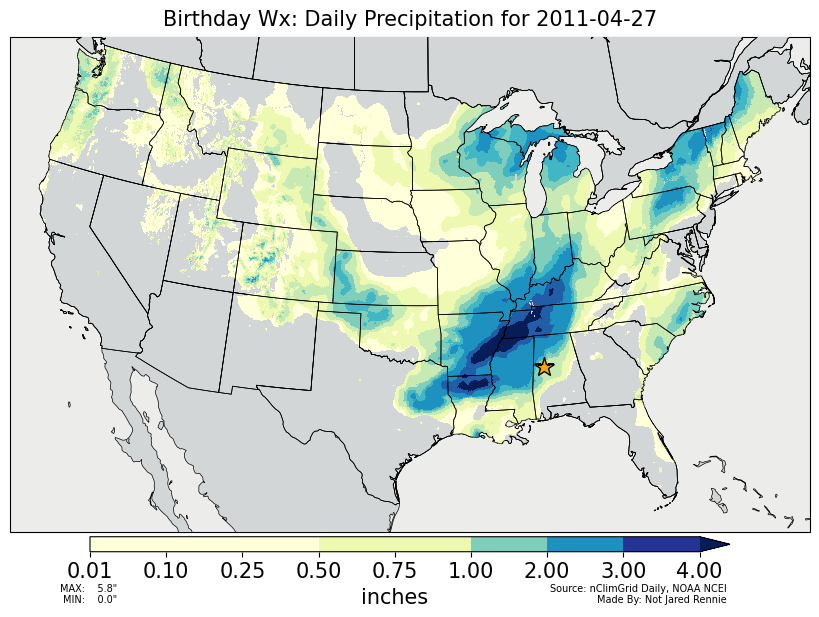

CPU times: user 962 ms, sys: 140 ms, total: 1.1 s
Wall time: 989 ms


In [16]:
%%time

#################################################
# PLOT
print("PLOTTING")
unit='inches'  
element_name='Precipitation'
colorMap='YlGnBu' 
bounds=np.array([0.01,0.10,0.25,0.50,0.75,1.00,2.00,3.00,4.00], dtype='f')

# Set Up Colorbar info
vmin=np.min(bounds)
vmax=np.max(bounds)
extend='max'
cmap = plt.get_cmap(colorMap, len(bounds))
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N, clip=True)
cm = plt.cm.ScalarMappable(cmap=cmap)
cm.set_array(np.array(conus_value))
cm.set_clim(vmin, vmax)

# Set Up Figure
fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.Geodetic())
ax.set_facecolor(ocean_hex)

# Add Boundaries
ax.add_feature(cfeature.LAND,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=3)
ax.add_feature(cfeature.LAKES,linewidth=0.5,facecolor=ocean_hex,edgecolor=edgecolor,zorder=4)
ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor=edgecolor,zorder=10)

# Plot Data
ax.pcolormesh(nclimgrid_lons, nclimgrid_lats, conus_value,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,zorder=9)

# Add Colorbar
cax = fig.add_axes([0.1, -0.035, 0.8, 0.03])
cbar=plt.colorbar(cm, cax=cax,boundaries=bounds,orientation='horizontal',extend=extend,spacing='uniform')
cbar.ax.tick_params(labelsize=15)
cbar.set_label(unit,size=15)

# Annotate Info On Graphic
nclimgrid_max="%6.1f" % np.nanmax(conus_value)
nclimgrid_min="%6.1f" % np.nanmin(conus_value)
plt.annotate('Source: nClimGrid Daily, NOAA NCEI\nMade By: '+author,xy=(1.045, -3.51), xycoords='axes fraction', fontsize=7,color='black',horizontalalignment='right', verticalalignment='bottom')
if element == "prcp":
    plt.annotate('MAX: '+str(nclimgrid_max)+'"\nMIN: '+str(nclimgrid_min)+'"',xy=(0.045, -3.51), xycoords='axes fraction', fontsize=7,color='black',horizontalalignment='right', verticalalignment='bottom')
else:
    plt.annotate('MAX: '+str(nclimgrid_max)+'°F\nMIN: '+str(nclimgrid_min)+'°F',xy=(0.045, -3.51), xycoords='axes fraction', fontsize=7,color='black',horizontalalignment='right', verticalalignment='bottom')

# Add Location
ax.plot(stnLon, stnLat, marker='*', markersize=15, markeredgecolor='black', linestyle='-', color='orange',transform=ccrs.PlateCarree(),zorder=101)

# Remove some variables (to save memory)
del data_monthly, conus_value, aws_file

# Add Title and show results
plt.suptitle('Birthday Wx: Daily '+element_name+' for '+current_date,size=15,color='black',y=1.05) 
plt.show() 
plt.clf()
plt.close()

## Birthday Wx: Surface Analysis, Incluing Sea Level Pressure and High/Lows <a class="anchor" id="seventh-bullet"></a>
Knowing temperature and precipitation is cool and all, but now we will get a sense of what the atmosphere looked like on the actual day you were born. Using reanalysis data from <a href="https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5" target="_blank">ERA5</a>, we will now get some atmospheric information about the day you were born. This particular version of the dataset is hosted by <a href='https://gdex.ucar.edu/datasets/d633000/' target='_blank'>NSF's UCAR</a>.

We will start by grabbing Sea Level Pressure, which we can use to analyze High/Lows and Frontal Systems.

In [17]:
%%time

# Get ERA5 Data (Sea Level Pressure, assuming 12 UTC)
numDays=monthrange(inYear, inMonth)[1]
inTime=12  # 12 UTC
target_time = pd.Timestamp(year=inYear, month=inMonth, day=inDay, hour=inTime)

fmtDate1= "%04i%02i" % (inYear,inMonth)
fmtDate2= "%04i%02i01" % (inYear,inMonth)
fmtDate3= "%04i%02i%02i" % (inYear,inMonth,numDays)
fmtDate4= "%04i-%02i-%02i" % (inYear,inMonth,inDay)

# Create an anonymous S3 filesystem (for public access)
fs = s3fs.S3FileSystem(anon=True)

## Path to your NetCDF file (SFC)
pathMSL = 's3://nsf-ncar-era5/e5.oper.an.sfc/'+fmtDate1+'/e5.oper.an.sfc.128_151_msl.ll025sc.'+fmtDate2+'00_'+fmtDate3+'23.nc'
print("READING IN FILE: ",pathMSL)

# Select the data at that exact time
dsMSL = xr.open_dataset(fs.open(pathMSL), engine='h5netcdf')
inDataMSL=dsMSL.sel(time=target_time)
inDataMSL=inDataMSL.MSL[:][:]
inDataMSL=inDataMSL/100.

# Grab lat/lon values (NAM will be 2D)
lats = inDataMSL.latitude.data
lons = inDataMSL.longitude.data

# Select and grab SLP
SLP = gaussian_filter(inDataMSL, sigma=3.0)
print("SUCCESS")

READING IN FILE:  s3://nsf-ncar-era5/e5.oper.an.sfc/201104/e5.oper.an.sfc.128_151_msl.ll025sc.2011040100_2011043023.nc
SUCCESS
CPU times: user 657 ms, sys: 76.4 ms, total: 733 ms
Wall time: 5.17 s


With Sea Level Pressure, we can identify weather fronts and pressure systems (High/Low). There is a few ways of going about this.

1) Use the Surface Coded Bulletins from <a href="https://www.wpc.ncep.noaa.gov/html/sfc2.shtml" target="_blank">NOAA's Weather Prediction Center</a>. This includes all types of fronts, and locations of Highs/Lows. An archive of this information can be found on the <a href="https://mesonet.agron.iastate.edu/wx/afos/" target="_blank">Iowa Environmental Mesonet's Archive Page</a>. If available, we can plot it all using <a href="https://unidata.github.io/MetPy/latest/examples/plots/Plotting_Surface_Analysis.html" target="_blank">MetPy</a>.
2) Calculate High and Low Pressure from the ERA5 Data. There is a calculation to do this through <a href="https://unidata.github.io/MetPy/latest/examples/calculations/High_Low_Analysis.html" target="_blank">MetPy</a>. This however does not have fronts. 

We will first try Option 1 (Fronts and Pressure systems). The codeblock below is a module from MetPy. 

In [18]:
from metpy.io import parse_wpc_surface_bulletin
from metpy.plots import (ColdFront, OccludedFront, scattertext, StationaryFront, WarmFront)

def plot_bulletin(ax, data):
    """Plot a dataframe of surface features on a map."""
    # Set some default visual styling
    size = 4
    fontsize = 9
    complete_style = {'HIGH': {'color': 'blue', 'fontsize': fontsize},
                      'LOW': {'color': 'red', 'fontsize': fontsize},
                      'WARM': {'linewidth': 1, 'path_effects': [WarmFront(size=size)]},
                      'COLD': {'linewidth': 1, 'path_effects': [ColdFront(size=size)]},
                      'OCFNT': {'linewidth': 1, 'path_effects': [OccludedFront(size=size)]},
                      'STNRY': {'linewidth': 1, 'path_effects': [StationaryFront(size=size)]},
                      'TROF': {'linewidth': 2, 'linestyle': 'dashed',
                               'edgecolor': 'darkorange'}}

    # Handle H/L points using MetPy's StationPlot class
    for field in ('HIGH', 'LOW'):
        rows = data[data.feature == field]
        x, y = zip(*((pt.x, pt.y) for pt in rows.geometry), strict=False)
        scattertext(ax, x, y, field[0],
                    **complete_style[field], transform=ccrs.PlateCarree(), clip_on=True,zorder=101)
        scattertext(ax, x, y, rows.strength, formatter='.0f', loc=(0, -10),
                    **complete_style[field], transform=ccrs.PlateCarree(), clip_on=True,zorder=101)

    # Handle all the boundary types
    for field in ('WARM', 'COLD', 'STNRY', 'OCFNT', 'TROF'):
        rows = data[data.feature == field]
        ax.add_geometries(rows.geometry, crs=ccrs.PlateCarree(), **complete_style[field],
                          facecolor='none',zorder=101)
print("SUCCESS")

SUCCESS


Now we will try and get data from <a href="https://mesonet.agron.iastate.edu/cgi-bin/afos/retrieve.py?help" target="_blank">IEM</a> to see if we can plot both fronts and High/Lows. If it doesn't work, we will only do a H/L calculation below.

In [19]:
%%time

hasFronts=False

# --- Build start/end dates (1-day window) ---
start_date = datetime(inYear, inMonth, inDay)
end_date = start_date + timedelta(days=1)

# --- Construct URL ---
# From https://mesonet.agron.iastate.edu/cgi-bin/afos/retrieve.py?help
base_url = "https://mesonet.agron.iastate.edu/cgi-bin/afos/retrieve.py"
params = {"limit": 1,"pil": "CODSUS","fmt": "text",
          "sdate": start_date.strftime("%Y-%m-%d"),
          "edate": end_date.strftime("%Y-%m-%d")}

# --- Download ---
r = requests.get(base_url, params=params)
r.raise_for_status()

# --- Save to file ---
outfile = f"CODSUS_{start_date.strftime('%Y%m%d')}.txt"
with open(outfile, "w") as f:
    f.write(r.text)

print(f"Saved bulletin to {outfile}")

# Parse the bulletin 
try:
    wpcFile='./CODSUS_'+start_date.strftime('%Y%m%d')+'.txt'
    print(wpcFile)
    dfWPC = parse_wpc_surface_bulletin(wpcFile)
    if len(dfWPC) <=1:
        print("ISSUE Getting Fronts! Can Only Plot High/Lows")
        os.remove(wpcFile)
    else:
        hasFronts=True
        print("SUCCESS Getting Fronts!")
except:
    print("ISSUE Getting Fronts! Can Only Plot High/Lows")

Saved bulletin to CODSUS_20110427.txt
./CODSUS_20110427.txt
SUCCESS Getting Fronts!
CPU times: user 19.3 ms, sys: 1.23 ms, total: 20.5 ms
Wall time: 11.7 s


We will now plot the results. Depending on the results above, it will either plot the information from WPC, or simply high and lows.

***NOTE: This may take some time to plot.***

PLOTTING, May take a moment...


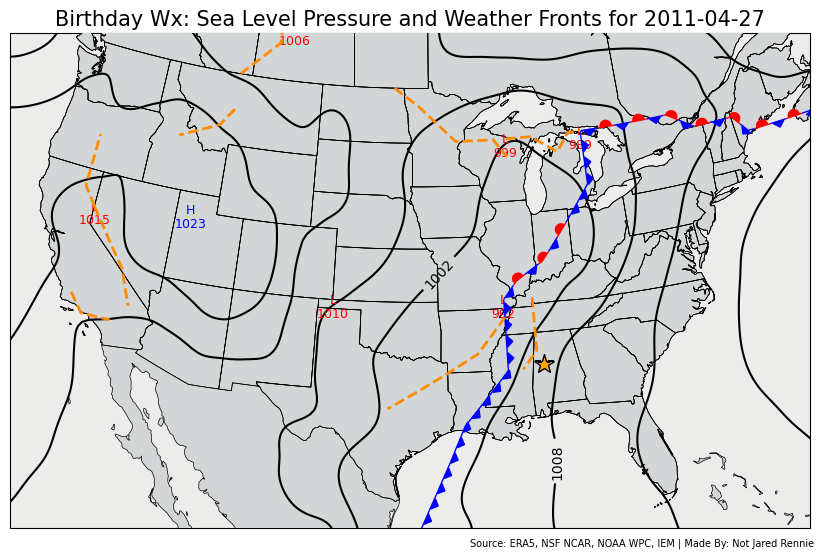

CPU times: user 11.1 s, sys: 189 ms, total: 11.3 s
Wall time: 11.1 s


In [20]:
%%time

#################################################
# PLOT
print("PLOTTING, May take a moment...")

# Build mask for H/L points near the map domain
lat_min, lat_max = (minLat-5.), (maxLat+5.)
lon_min, lon_max = (minLon+355.), (maxLon+365.)

# Set Up Figure
fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')

# CONUS AXES
conus_ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
conus_ax.set_facecolor(ocean_hex)
conus_ax.spines['geo'].set_edgecolor(edgecolor)
conus_ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.Geodetic())

# Add other Features
conus_ax.add_feature(cfeature.LAND,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=3)
conus_ax.add_feature(cfeature.LAKES,linewidth=0.5,facecolor=ocean_hex,edgecolor=edgecolor,zorder=4)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor=edgecolor,zorder=10)

# Plot SLP in meters
clevs_SLP_hght = np.arange(0, 8000, 6)
cs = conus_ax.contour(lons, lats, SLP, clevs_SLP_hght, colors='black',transform=ccrs.PlateCarree(),zorder=99)
plt.clabel(cs, fmt='%d')

if hasFronts:
    plot_bulletin(conus_ax, dfWPC)
    os.remove(wpcFile)
else:
    # Find High/Low
    h_y, h_x = find_peaks(SLP)
    l_y, l_x = find_peaks(SLP, maxima=False)
    
    # PLOT HIGH
    lon_vals = np.array(lons[h_x], dtype=float)
    lat_vals = np.array(lats[h_y], dtype=float)
    
    # Build mask for points inside the map domain and plot
    mask = ((lon_vals >= lon_min) & (lon_vals <= lon_max) &(lat_vals >= lat_min) & (lat_vals <= lat_max))
    for lon, lat in zip(lon_vals[mask], lat_vals[mask]):
        conus_ax.text(lon, lat, 'H',color='blue', fontsize=16, fontweight='bold',ha='center', va='center',transform=ccrs.PlateCarree(),zorder=100)
    
    # PLOT LOW
    lon_vals = np.array(lons[l_x], dtype=float)
    lat_vals = np.array(lats[l_y], dtype=float)
    
    # Build mask for points inside the map domain and plot
    mask = ((lon_vals >= lon_min) & (lon_vals <= lon_max) &(lat_vals >= lat_min) & (lat_vals <= lat_max))
    for lon, lat in zip(lon_vals[mask], lat_vals[mask]):
        conus_ax.text(lon, lat, 'L',color='red', fontsize=16, fontweight='bold',ha='center', va='center',transform=ccrs.PlateCarree(),zorder=100)

# Add Location
conus_ax.plot(stnLon, stnLat, marker='*', markersize=15, markeredgecolor='black', linestyle='-', color='orange',transform=ccrs.PlateCarree(),zorder=101)

# Remove some variables (to save memory)
del SLP, inDataMSL, dsMSL

# Make some nice titles for the plot, then show!
plt.annotate('Source: ERA5, NSF NCAR, NOAA WPC, IEM | Made By: '+author,xy=(1.005, -0.04), xycoords='axes fraction', fontsize=7,color='black',horizontalalignment='right', verticalalignment='bottom')
plt.title('Birthday Wx: Sea Level Pressure and Weather Fronts for '+fmtDate4,size=15,color='black')
plt.show()
plt.clf()
plt.close()

## Birthday Wx: Tropical Cyclones <a class="anchor" id="trop-bullet"></a>
For the hurricane hunters out there, we will now get tropical cyclone tracks for the season you were born. We are grabbing data from the <a href="https://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html" target="_blank">HURDAT Dataset</a> hosted by <a href="https://www.ncei.noaa.gov/" target="_blank">NOAA's National Centers for Environmental Information</a>. We will be using <a href="https://tropycal.github.io/tropycal/" target="_blank">the TroPYcal Python package</a> to plot the information for 2 basins (Atlantic and Pacific).

In [21]:
%%time 

tracks_all = tracks.TrackDataset(basin='both',include_btk=True)
tracks_all

--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (2.23 seconds)
--> Starting to read in best track data
--> Completed reading in best track data (8.13 seconds)
CPU times: user 2.14 s, sys: 58.8 ms, total: 2.2 s
Wall time: 30.9 s


<tropycal.tracks.Dataset>
Dataset Summary:
    Basin:             both
    Source:            hurdat
    Number of storms:  3257
    Maximum wind:      185 knots (Patricia 2015)
    Minimum pressure:  872 hPa (Patricia 2015)
    Year range:        1851 — 2025

The dataset includes all Tropical Cyclones from 1851- Present, so let's extract data for the year you were born.

In [22]:
indSeason =  tracks_all.get_season(inYear)
indSeason

<tropycal.tracks.Season>
Season Summary:
    Total Storms:      33
    Named Storms:      30
    Hurricanes:        17
    Major Hurricanes:  10
    Season ACE:        247.1

More Information:
    year:          2011
    basin:         both
    source_basin:  north_atlantic
    source:        hurdat
    source_info:   NHC Hurricane Database

Now let's plot!

CPU times: user 1.12 s, sys: 10.2 ms, total: 1.14 s
Wall time: 1.13 s


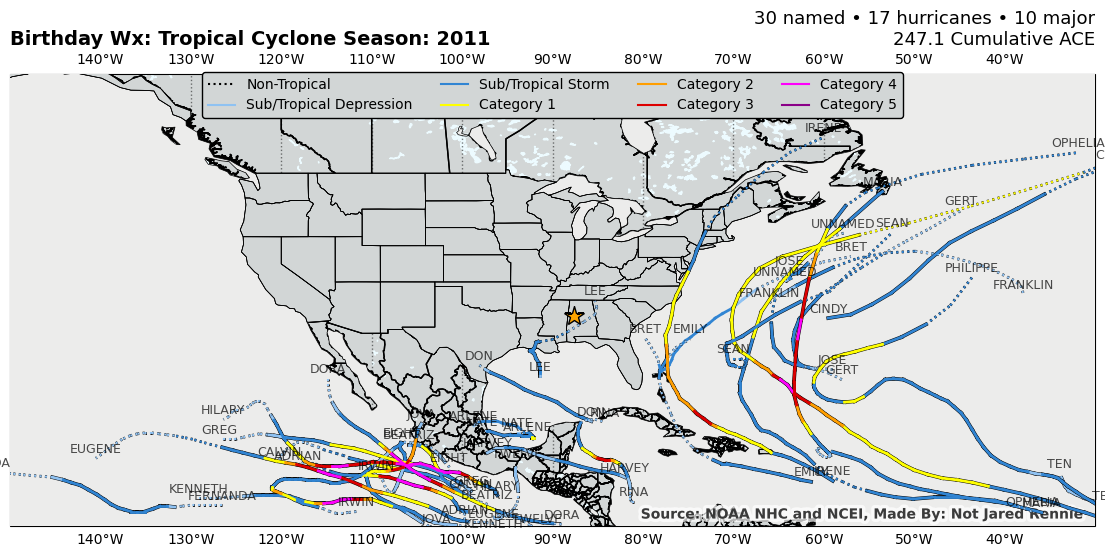

In [23]:
%%time

# Plot The Tracks
ax = indSeason.plot(
    domain={'n':10,'s':60,'w':-150,'e':-30},
    plot_all_dots=True,
    map_prop={
        'figsize': (14, 9),
        'linewidth': 1.0,
        'res': 'h',
        'dpi': dpi
    },
    prop={
    'linewidth':2.0
    }
)

# Add Land Features
ax.set_facecolor(ocean_hex)
ax.add_feature(cfeature.LAKES,linewidth=0.5,facecolor=ocean_hex,edgecolor='black',zorder=8)
ax.add_feature(cfeature.OCEAN,linewidth=0.5,facecolor=ocean_hex,edgecolor='black',zorder=8)
ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor='black',zorder=9)
ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor='black',zorder=10)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m'),facecolor=land_hex,edgecolor='black', linewidth=0.2,zorder=0)

# Add Location
ax.plot(stnLon, stnLat, marker='*', markersize=15, markeredgecolor='black', linestyle='-', color='orange',transform=ccrs.PlateCarree(),zorder=101)

# Make Edits to the Title
ax.set_title("Birthday Wx: Tropical Cyclone Season: " + str(inYear),loc='left',fontweight='bold',fontsize=14)

# Male Edits to the Text
for text in ax.texts:
    if "troPYcal" in text.get_text():
        style_reference = text
        text.set_text("Source: NOAA NHC and NCEI, Made By: "+author)

# Make Edits to the Legend
legend = ax.get_legend()
if legend:
    handles = legend.legendHandles
    labels = [t.get_text() for t in legend.texts]

    legend.remove()   # remove the original

    legend = ax.legend(
        handles,
        labels,
        ncol=4,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.02),
        frameon=True
    )

    # Style
    legend.set_zorder(1e6)
    frame = legend.get_frame()
    frame.set_facecolor(land_hex)
    frame.set_edgecolor('black')
    frame.set_alpha(1.0)

This shows both the North Atlantic and East Pacific Basin

***Let's zoom in on your birth Location!***

CPU times: user 1.09 s, sys: 20 ms, total: 1.11 s
Wall time: 1.11 s


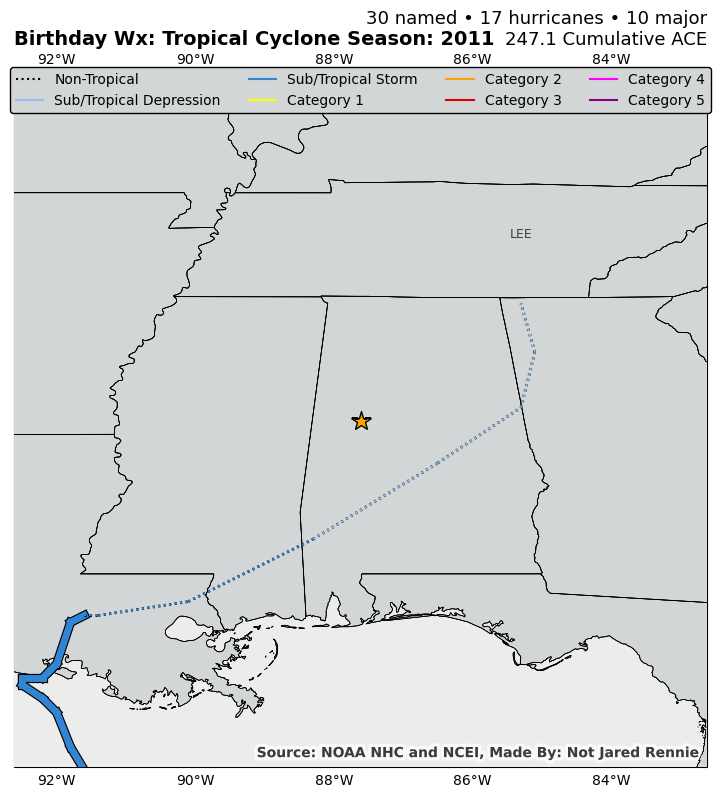

In [24]:
%%time

# Plot The Tracks
ax = indSeason.plot(
    domain={'n':(stnLat-5),'s':(stnLat+5),'w':(stnLon-5),'e':(stnLon+5)},
    plot_all_dots=True,
    map_prop={
        'figsize': (14, 9),
        'linewidth': 1.0,
        'res': 'h',
        'dpi': dpi
    },
    prop={
    'linewidth':5,
    'plot_names':True
    }
)

# Add Land Features
ax.set_facecolor(ocean_hex)
ax.add_feature(cfeature.LAKES,linewidth=0.5,facecolor=ocean_hex,edgecolor='black',zorder=8)
ax.add_feature(cfeature.OCEAN,linewidth=0.5,facecolor=ocean_hex,edgecolor='black',zorder=8)
ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor='black',zorder=9)
ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor='black',zorder=10)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m'),facecolor=land_hex,edgecolor='black', linewidth=0.2,zorder=0)

# Add Location
ax.plot(stnLon, stnLat, marker='*', markersize=15, markeredgecolor='black', linestyle='-', color='orange',transform=ccrs.PlateCarree(),zorder=101)

# Make Edits to the Title
ax.set_title("Birthday Wx: Tropical Cyclone Season: " + str(inYear),loc='left',fontweight='bold',fontsize=14)

# Male Edits to the Text
for text in ax.texts:
    if "troPYcal" in text.get_text():
        style_reference = text
        text.set_text("Source: NOAA NHC and NCEI, Made By: "+author)

# Make Edits to the Legend
legend = ax.get_legend()
if legend:
    handles = legend.legendHandles
    labels = [t.get_text() for t in legend.texts]

    legend.remove()   # remove the original

    legend = ax.legend(
        handles,
        labels,
        ncol=4,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.02),
        frameon=True
    )

    # Style
    legend.set_zorder(1e6)
    frame = legend.get_frame()
    frame.set_facecolor(land_hex)
    frame.set_edgecolor('black')
    frame.set_alpha(1.0)

# Remove some variables (to save memory)
del tracks_all

**CONGRATS!!** you are now an expert at grabbing data from AWS (and elsewhere) and plotting it like a pro! 

If you are savvy, try and edit the code above to your liking. There are many other variables to look at, and ways to slice/dice/visualize data.

Below are some more ways to visualize data, but may be a little technical for the non-meteorologist. 

* [BONUS: Upper Atmosphere Winds (Approximately 30,000 feet)](#eighth-bullet)
* [BONUS: Drought Monitor (2000-Present)](#ninth-bullet)
* [BONUS: Snowfall Analysis (2009-Present)](#tenth-bullet)
* [BONUS: Storm Reports (Hail, Wind, Tornadoes, 1950-Present)](#eleventh-bullet)

However might want to clean up some memory first....the next few ones are memory intensive

In [25]:
import gc 
gc.collect()

85856

## BONUS: Upper Atmosphere Winds (Approximately 30,000 feet) <a class="anchor" id="eighth-bullet"></a>
If you are weather savvy, you can get upper atmospheric information at different pressure levels. For this example we will use the 300mb level (typically where the jet stream is, about 30,000 feet in the sky)

In [26]:
%%time

# Get ERA5 Data (300mb Winds and Heights)
fmtDate1= "%04i%02i" % (inYear,inMonth)
fmtDate2= "%04i%02i%02i" % (inYear,inMonth,inDay)

# Create an anonymous S3 filesystem (for public access)
fs = s3fs.S3FileSystem(anon=True)

# Path to your NetCDF file (Pressure Level - PL)
pathZ = 's3://nsf-ncar-era5/e5.oper.an.pl/'+fmtDate1+'/e5.oper.an.pl.128_129_z.ll025sc.'+fmtDate2+'00_'+fmtDate2+'23.nc'
pathU = 's3://nsf-ncar-era5/e5.oper.an.pl/'+fmtDate1+'/e5.oper.an.pl.128_131_u.ll025uv.'+fmtDate2+'00_'+fmtDate2+'23.nc'
pathV = 's3://nsf-ncar-era5/e5.oper.an.pl/'+fmtDate1+'/e5.oper.an.pl.128_132_v.ll025uv.'+fmtDate2+'00_'+fmtDate2+'23.nc'

# Open the file directly from S3
print("READING IN: ",pathZ)
dsZ = xr.open_dataset(fs.open(pathZ), engine='h5netcdf')
print("READING IN: ",pathU)
dsU = xr.open_dataset(fs.open(pathU), engine='h5netcdf')
print("READING IN: ",pathV)
dsV = xr.open_dataset(fs.open(pathV), engine='h5netcdf')

inTime=12  # 12 UTC
inLevel=17 # 300 hPa/mb

inDataZ=dsZ.Z[inTime][inLevel][:][:]
inDataU=dsU.U[inTime][inLevel][:][:]
inDataV=dsV.V[inTime][inLevel][:][:]

# Grab lat/lon values (NAM will be 2D)
lats = inDataZ.latitude.data
lons = inDataZ.longitude.data

# Select and grab 300-hPa geopotential heights and wind components, smooth with gaussian_filter
inDataZ = inDataZ/100.
hght_300 = gaussian_filter(inDataZ, sigma=3.0)
uwnd_300 = gaussian_filter(inDataU, sigma=3.0) * units('m/s')
vwnd_300 = gaussian_filter(inDataV, sigma=3.0) * units('m/s')

# Use MetPy to calculate the wind speed for colorfill plot, change units to knots from m/s
sped_300 = mpcalc.wind_speed(uwnd_300, vwnd_300).to('kt')

# Remove some variables (to save memory)
del inDataZ, inDataU, inDataV, dsZ, dsU, dsV

print("SUCCESS")

READING IN:  s3://nsf-ncar-era5/e5.oper.an.pl/201104/e5.oper.an.pl.128_129_z.ll025sc.2011042700_2011042723.nc
READING IN:  s3://nsf-ncar-era5/e5.oper.an.pl/201104/e5.oper.an.pl.128_131_u.ll025uv.2011042700_2011042723.nc
READING IN:  s3://nsf-ncar-era5/e5.oper.an.pl/201104/e5.oper.an.pl.128_132_v.ll025uv.2011042700_2011042723.nc
SUCCESS
CPU times: user 2.17 s, sys: 684 ms, total: 2.85 s
Wall time: 11.6 s


PLOTTING, May take a moment...


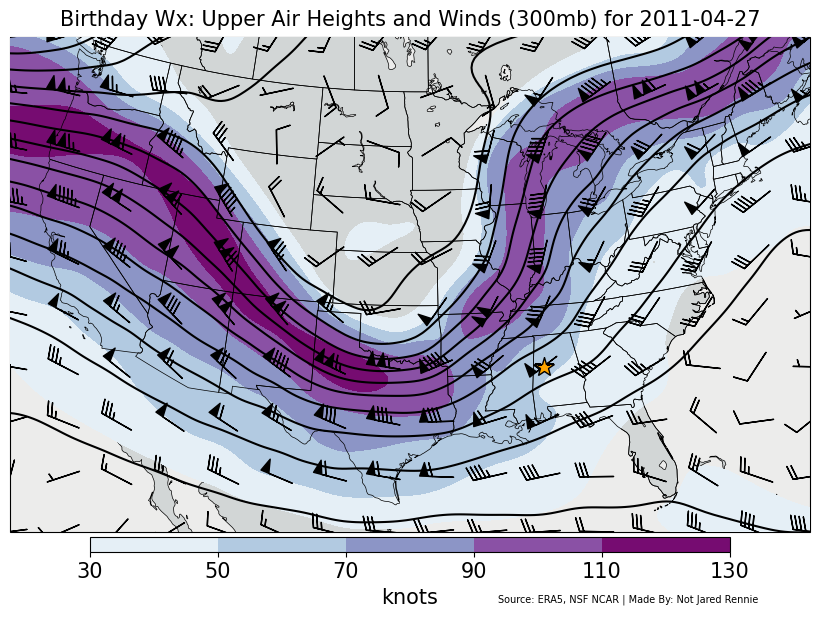

CPU times: user 55.4 s, sys: 12.1 s, total: 1min 7s
Wall time: 55.6 s


In [27]:
%%time

#################################################
# PLOT
print("PLOTTING, May take a moment...")
unit='knots'

# Set Up Figure
fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')

# CONUS AXES
conus_ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
conus_ax.set_facecolor(ocean_hex)
conus_ax.spines['geo'].set_edgecolor(edgecolor)
conus_ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.Geodetic())

# Add other Features
conus_ax.add_feature(cfeature.LAND,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=3)
conus_ax.add_feature(cfeature.LAKES,linewidth=0.5,facecolor=ocean_hex,edgecolor=edgecolor,zorder=4)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor=edgecolor,zorder=101)

# Plot 300-hPa Colorfill Wind Speeds in knots
clevs_300_sped = np.arange(30, 150, 20)
cf = conus_ax.contourf(lons, lats, sped_300, clevs_300_sped, cmap=plt.cm.BuPu,transform=ccrs.PlateCarree(),zorder=98)

# Plot 300-hPa Geopotential Heights in meters
clevs_300_hght = np.arange(0, 8000, 6)
cs = conus_ax.contour(lons, lats, hght_300, clevs_300_hght, colors='black',transform=ccrs.PlateCarree(),zorder=99)
plt.clabel(cs, fmt='%d')

# Plot 300-hPa wind barbs in knots, regrid to reduce number of barbs
conus_ax.barbs(lons, lats, uwnd_300.to('kt').m, vwnd_300.to('kt').m, pivot='middle',color='black', regrid_shape=10, transform=ccrs.PlateCarree(),zorder=100)

# Add Location
conus_ax.plot(stnLon, stnLat, marker='*', markersize=15, markeredgecolor='black', linestyle='-', color='orange',transform=ccrs.PlateCarree(),zorder=101)

# Add Colorbar
cax = fig.add_axes([0.1, -0.035, 0.8, 0.03])
cbar=plt.colorbar(cf, cax=cax,orientation='horizontal',spacing='uniform')
cbar.ax.tick_params(labelsize=15)
cbar.set_label(unit,size=15)

# Remove some variables (to save memory)
del sped_300, hght_300, uwnd_300, vwnd_300

# Make some nice titles for the plot, then show!
plt.annotate('Source: ERA5, NSF NCAR | Made By: '+author,xy=(1.045, -3.51), xycoords='axes fraction', fontsize=7,color='black',horizontalalignment='right', verticalalignment='bottom')
plt.suptitle('Birthday Wx: Upper Air Heights and Winds (300mb) for '+fmtDate4,size=15,color='black',y=1.05)
plt.show()
plt.clf()
plt.close()

## BONUS: Drought Monitor (2000-Present) <a class="anchor" id="ninth-bullet"></a>
If you were born in the 21st Century, you can get drought information from the  <a href="https://droughtmonitor.unl.edu/" target="_blank">United States Drought Monitor.</a> The data comes out weekly so this block of code will look for the closest one to your birthday.

In [28]:
%%time

# Get USDM Product date (note that it only goes back to 2000)
if inYear>=2000:
    inDate = date(inYear, inMonth, inDay)
    
    # Difference in days between tuesday (1) and current weekday
    delta = 1 - inDate.weekday()
    
    # Adjust to the nearest Tuesday (could be before or after)
    if delta > 3:
        delta -= 7
    elif delta < -3:
        delta += 7
    
    usdmDate = inDate + timedelta(days=delta)
    print('USDM Date: ',usdmDate)
else:
    print('Sorry, USDM starts in the year 2000')    

USDM Date:  2011-04-26
CPU times: user 42 µs, sys: 7 µs, total: 49 µs
Wall time: 51.3 µs


Download the data from the <a href="https://droughtmonitor.unl.edu/" target="_blank">USDM Website.</a>. Since this data is not hosted by AWS, we have to install some more packages to pull it down locally.

In [29]:
%%time

# Install additional packages to download and organize data
import requests, zipfile, io, shutil

# Format the date as YYYYMMDD for the filename
date_str = usdmDate.strftime("%Y%m%d")

# Build the download URL
url = f"https://droughtmonitor.unl.edu/data/shapefiles_m/USDM_{date_str}_M.zip"
print("Downloading:", url)

# Download the file
response = requests.get(url)
response.raise_for_status()  # Raise an error if the request failed

# Unzip into a folder named after the date
out_dir = f"USDM_{date_str}_M"

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall(out_dir)

print(f"SUCCESS! Unzipped to: {out_dir}")

Downloading: https://droughtmonitor.unl.edu/data/shapefiles_m/USDM_20110426_M.zip
SUCCESS! Unzipped to: USDM_20110426_M
CPU times: user 31.1 ms, sys: 1.04 ms, total: 32.1 ms
Wall time: 519 ms


Now Read in the file and plot it

In [30]:
import geopandas as gpd
import cartopy.io.shapereader as shpreader

# READ IN SHAPEFILE
input_shapefile=out_dir+'/USDM_'+date_str+'.shp'
print("READ IN SHAPEFILE: ",input_shapefile)
geo_shapefile = gpd.read_file(input_shapefile)

print("SUCCESS")

READ IN SHAPEFILE:  USDM_20110426_M/USDM_20110426.shp
SUCCESS


PLOTTING


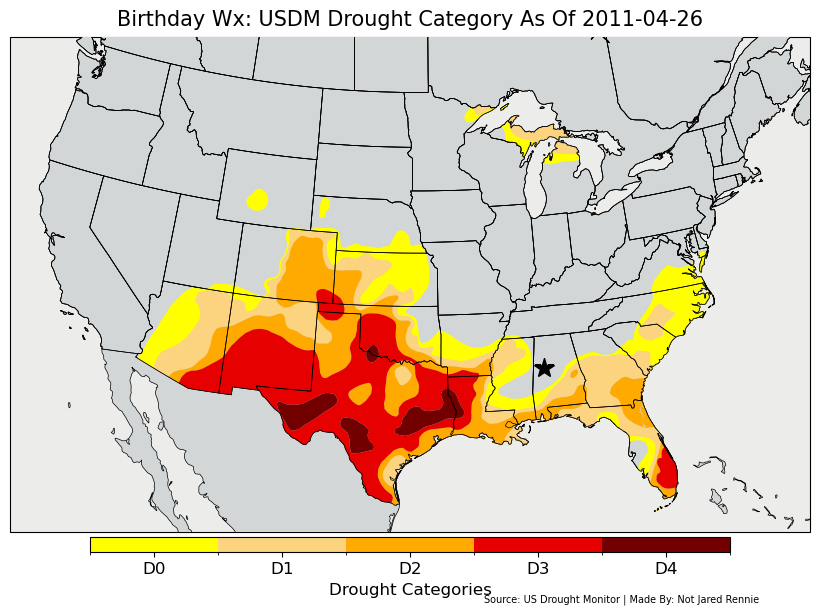

CPU times: user 4.68 s, sys: 100 ms, total: 4.78 s
Wall time: 4.67 s


In [31]:
%%time

#################################################
# PLOTTING 
print("PLOTTING")

# Set Up Figure
fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.Geodetic())
ax.set_facecolor(ocean_hex)

# Plot Data For Each USDM Category (D0-D4)
attribute_counter=0
for categories in shpreader.Reader(input_shapefile).geometries():
    val=geo_shapefile.iloc[attribute_counter]['DM']
    if val==0:
        outColor='#FFFF00'
    if val==1:
        outColor='#FCD37F'
    if val==2:
        outColor='#FFAA00'
    if val==3:
        outColor='#E60000'
    if val==4:
        outColor='#730000'
    ax.add_geometries([categories], ccrs.PlateCarree(),facecolor=outColor, edgecolor='None',linewidth=0.10,zorder=10)
    attribute_counter+=1
ax.add_feature(cfeature.LAND,linewidth=0.5,facecolor=land_hex,edgecolor='black',zorder=7)
ax.add_feature(cfeature.LAKES,linewidth=0.5,facecolor=ocean_hex,edgecolor='black',zorder=8)
ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor='black',zorder=9)
ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor='black',zorder=10)

# Add ColorMap 
cmap = mpl.colors.ListedColormap(['#FFFF00', '#FCD37F', '#FFAA00', '#E60000', '#730000'])
bounds = np.arange(cmap.N+1) 
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cax = fig.add_axes([0.1, -0.035, 0.8, 0.03])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cax, boundaries=bounds, ticks=bounds, spacing='uniform', orientation='horizontal')

# Define tick locations and labels
labels=np.array(['D0','D1','D2','D3','D4'],dtype='str')
tick_locations = np.arange(0.5, float(len(labels)+0.5), 1)  # Adjust the number of tick locations to match the number of boundaries
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(labels)
cbar.set_label('Drought Categories',size=12)
cbar.ax.tick_params(labelsize=12)

# Add Location
ax.plot(stnLon, stnLat, marker='*', markersize=15, markeredgecolor='black', linestyle='-', color='black',transform=ccrs.PlateCarree(),zorder=101)

# Add Titles
plt.suptitle("Birthday Wx: USDM Drought Category As Of "+usdmDate.strftime("%Y-%m-%d"),size=15,color='black',y=1.05) 
plt.annotate('Source: US Drought Monitor | Made By: '+author,xy=(1.045, -3.51), xycoords='axes fraction', fontsize=7,color='black',horizontalalignment='right', verticalalignment='bottom')

# Rm file
shutil.rmtree(out_dir)

# Remove some variables (to save memory)
del geo_shapefile

# Show Figure
plt.show()
plt.clf()
plt.close()

## BONUS: Snowfall Analysis (2009-Present) <a class="anchor" id="tenth-bullet"></a>
If you were born 2009 or later, you can get gridded snowfall information from the  <a href="https://www.nohrsc.noaa.gov/" target="_blank">National Operational Hydrologic
Remote Sensing Center.</a> This block of code will look for data on your birth day.

In [32]:
# Get USDM Product date (note that it only goes back to 2000)
if inYear>=2009:
    snowDate = date(inYear, inMonth, inDay)
    print('NOHRSC SNOW Date: ',snowDate)
else:
    print('Sorry, NOHRSC SNOW starts in the year 2009')

NOHRSC SNOW Date:  2011-04-27


Download the data from the <a href="https://www.nohrsc.noaa.gov/snowfall_v2/" target="_blank">Snow Website.</a>. Since this data is not hosted by AWS, we have to install some more packages to pull it down locally.

In [33]:
%%time

# Install additional packages to download and organize data
import requests, zipfile, io, os

# Format the date as YYYYMM/YYYYMMDD for the filename
date_str1 = snowDate.strftime("%Y%m")
date_str2 = snowDate.strftime("%Y%m%d")

# Build the download URL
url = f"https://www.nohrsc.noaa.gov/snowfall_v2/data/{date_str1}/sfav2_CONUS_24h_{date_str2}12.nc"
print("Downloading:", url)

# Download the file
response = requests.get(url)
response.raise_for_status()  # Raise an error if the request failed

# Define output filename
outfile = f"sfav2_CONUS_24h_{date_str2}12.nc"

# Save to disk
with open(outfile, "wb") as f:
    f.write(response.content)
print("SUCCESS")

Downloading: https://www.nohrsc.noaa.gov/snowfall_v2/data/201104/sfav2_CONUS_24h_2011042712.nc
SUCCESS
CPU times: user 10.2 ms, sys: 8.53 ms, total: 18.7 ms
Wall time: 572 ms


In [34]:
%%time

#################################################
# READ IN DAILY SNOW DATA

# Grab Data
infile='./sfav2_CONUS_24h_'+date_str2+'12.nc'
print('READING IN DAILY DATA: ',infile)
try:
    inData = xr.open_dataset(infile,engine="netcdf4")
except:
    print("\tERROR: Issue opening file!")
lats=inData.lat.values
lons=inData.lon.values

# Convert m to ft
daily_snow_feet=(inData.Data.values * 3.28084)
currFeet=daily_snow_feet

# Convert m to inches
daily_snow_inches=(inData.Data.values * 39.3701)
currInches=daily_snow_inches

print('SUCCESS')

READING IN DAILY DATA:  ./sfav2_CONUS_24h_2011042712.nc
SUCCESS
CPU times: user 29.6 ms, sys: 0 ns, total: 29.6 ms
Wall time: 29.5 ms


PLOTTING DATA
	 MIN:  0.1 Inches  | MAX:  1.0 Feet


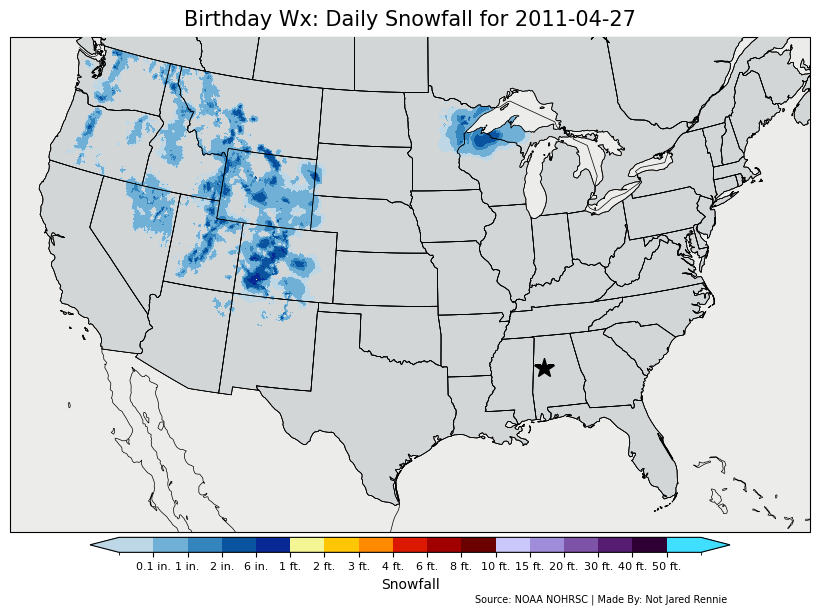

CPU times: user 1.86 s, sys: 111 ms, total: 1.97 s
Wall time: 2.81 s


In [35]:
%%time

#################################################
# PLOTTING DATA
print("PLOTTING DATA")

#################################################
# Custom Snowfall CMAP
# http://schubert.atmos.colostate.edu/~cslocum/custom_cmap.html
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

value_max="%.1f" % np.nanmax(daily_snow_feet[np.nonzero(daily_snow_feet)])
value_min="%.1f" % np.nanmin(daily_snow_feet[np.nonzero(daily_snow_feet)])

if float(value_max) < 1:
    value_max="%.1f" % np.nanmax(daily_snow_inches[np.nonzero(daily_snow_inches)])
    if float(value_max) < 0.1:
        value_max="%.1f" % (0.1)
    out_max=value_max+' Inches'
else:
    out_max=value_max+' Feet'
if float(value_min) < 1:
    value_min="%.1f" % np.nanmin(daily_snow_inches[np.nonzero(daily_snow_inches)])
    if float(value_min) < 0.1:
        value_min="%.1f" % (0.1)
    out_min=value_min+' Inches'
else:
    out_min=value_min+' Feet'
print('\t MIN: ',out_min,' | MAX: ',out_max)

# Set some Plotting Parameters
element='snow-val'
element_name='Snowfall Accumulation'
unit='Snowfall'
cmap='YlGnBu'

colors = [(189,215,231), (107,174,214), \
          (49,130,189), (8,81,156),  (8,38,148),\
          (255,255,150), (255,196,0),  (255,135,0),\
          (219,20,0), (158,0,0),  (105,0,0),\
          (204,204,255), (159,140,216),  (124,82,165),\
          (86,28,114), (46,0,51),  (64,223,255),\
          ] 
# This example uses the 8-bit RGB
cmap = make_cmap(colors, bit=True)
bounds=np.array([0,0.1,1,2,6,12,24,36,48,72,96,120,180,240,360,480,600,5000])
bounds2=np.array(['0.1 in.','1 in.','2 in.','6 in.','1 ft.','2 ft.','3 ft.','4 ft.','6 ft.','8 ft.','10 ft.','15 ft.','20 ft.','30 ft.','40 ft.','50 ft.'],dtype=str)

# Set Up Figure
vmin=np.min(bounds)
vmax=np.max(bounds)
extend='both'
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)
cm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
cm.set_array(np.array(daily_snow_inches))
cm.set_clim(vmin, vmax)

fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.Geodetic())
ax.set_facecolor(ocean_hex)
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.BORDERS,linewidth=0.5)
ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,zorder=9)
ax.add_feature(cfeature.STATES,linewidth=0.5,zorder=10)

# Plot Data
# Mask Values less than 0
vals_nonmiss=ma.masked_where(daily_snow_inches <= 0, daily_snow_inches)
ax.pcolormesh(lons, lats, vals_nonmiss,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,zorder=9)

# Plot Colorbar
cax = fig.add_axes([0.1, -0.035, 0.8, 0.03])
cbar=plt.colorbar(cm, cax=cax,boundaries=bounds,orientation='horizontal',extend=extend,spacing='uniform')
cbar.set_ticks(bounds[1:17])
cbar.ax.set_xticklabels(bounds2)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(unit,size=10)

# Add Location
ax.plot(stnLon, stnLat, marker='*', markersize=15, markeredgecolor='black', linestyle='-', color='black',transform=ccrs.PlateCarree(),zorder=101)

# Add Titles
plt.suptitle("Birthday Wx: Daily Snowfall for "+snowDate.strftime("%Y-%m-%d"),size=15,color='black',y=1.05) 
plt.annotate('Source: NOAA NOHRSC | Made By: '+author,xy=(1.045, -3.51), xycoords='axes fraction', fontsize=7,color='black',horizontalalignment='right', verticalalignment='bottom')
plt.annotate('MIN: '+str(out_min)+' | MAX: '+str(out_max),xy=(0.245, -3.51), xycoords='axes fraction', fontsize=7,color='white',horizontalalignment='right', verticalalignment='bottom')

# Remove some variables (to save memory)
del inData, daily_snow_feet, daily_snow_inches

# Rm file
os.remove(infile)

# Show Figure
plt.show()
plt.clf()
plt.close()

## BONUS: Storm Reports (Hail, Wind, Tornadoes, 1950-Present)<a class="anchor" id="eleventh-bullet"></a>
Here we will get storm reports from <a href="https://www.ncei.noaa.gov/maps/swdi/" target="_blank">NCEIs Severe Weather Data Inventory</a>. For simplicity, we will only grab Hail, Wind and Tornadoes. Since this data is not hosted by AWS, we have to install some more packages to pull it down locally.

In [36]:
%%time

# Install additional packages to download and organize data
import requests, gzip, shutil, re, os

# NOAA directory for Storm Events data
base_url = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/"

# Fetch directory listing
r = requests.get(base_url)
r.raise_for_status()

# Find file for the given year
pattern = fr"StormEvents_details-ftp_v1\.0_d{inYear}_c\d{{8}}\.csv\.gz"
matches = re.findall(pattern, r.text)

if not matches:
    raise ValueError(f"No file found for year {inYear}")

filename = matches[0]
file_url = base_url + filename

print("Downloading:", file_url)

# Download the .gz file
response = requests.get(file_url)
response.raise_for_status()

# Save compressed file locally
gz_path = filename
with open(gz_path, "wb") as f:
    f.write(response.content)

# Decompress .gz -> .csv
input_csv = gz_path[:-3]  # remove '.gz'
with gzip.open(gz_path, "rb") as f_in, open(input_csv, "wb") as f_out:
    shutil.copyfileobj(f_in, f_out)

# Reads in Data and removes gz file
os.remove(gz_path)
inData = pd.read_csv(input_csv,sep=',')

print(f" SUCCESS! Decompressed and Read In: {input_csv}")

Downloading: https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2011_c20250520.csv.gz
 SUCCESS! Decompressed and Read In: StormEvents_details-ftp_v1.0_d2011_c20250520.csv
CPU times: user 806 ms, sys: 115 ms, total: 921 ms
Wall time: 1.44 s


In [37]:
%%time

# Get Subset of Data, based on inputs
stormDate = date(inYear, inMonth, inDay)
inYearMonth = stormDate.strftime("%Y%m")
inData['BEGIN_YEARMONTH'] = inData['BEGIN_YEARMONTH'].astype(str).str.strip()

subsetData=inData[(inData['BEGIN_YEARMONTH']==inYearMonth) & (inData['BEGIN_DAY']==inDay)]

outLats=subsetData['BEGIN_LAT'].values
outLons=subsetData['BEGIN_LON'].values
num_events=len(subsetData)

eventTor=subsetData[subsetData['EVENT_TYPE']=='Tornado']
eventHail=subsetData[subsetData['EVENT_TYPE']=='Hail']
eventWind=subsetData[subsetData['EVENT_TYPE']=='Thunderstorm Wind']

# Organize Values for Plotting
outLats1=eventTor['BEGIN_LAT'].values
outLons1=eventTor['BEGIN_LON'].values
outState1=eventTor['STATE'].values
numStns1=len(outLats1)

outLats2=eventHail['BEGIN_LAT'].values
outLons2=eventHail['BEGIN_LON'].values
outState2=eventHail['STATE'].values
numStns2=len(outLats2)

outLats3=eventWind['BEGIN_LAT'].values
outLons3=eventWind['BEGIN_LON'].values
outState3=eventWind['STATE'].values
numStns3=len(outLats3)
print('SUCCESS')

SUCCESS
CPU times: user 27.3 ms, sys: 0 ns, total: 27.3 ms
Wall time: 26.5 ms


PLOTTING
Plot 1st Criteria:  Tornado (329)
Plot 2nd Criteria:  Hail (195)
Plot 3rd Criteria:  Thunderstorm Wind (372)


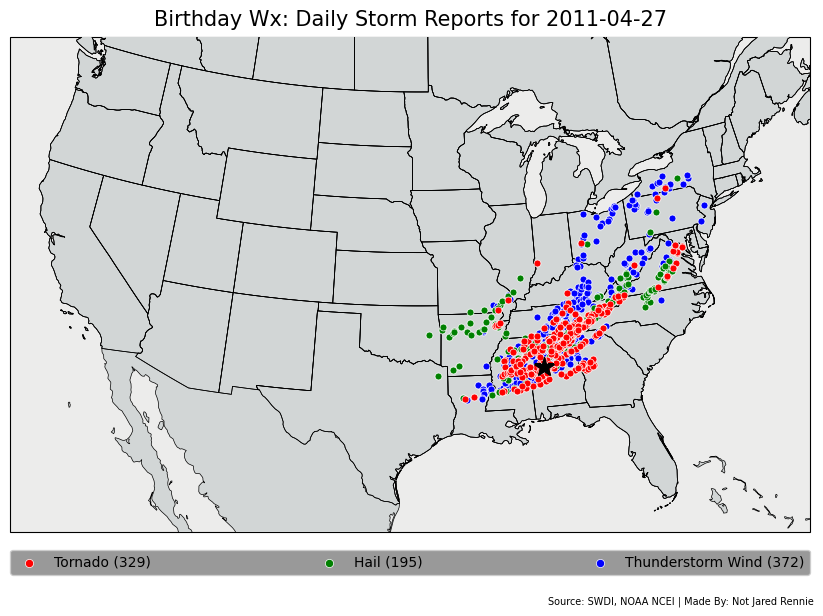

CPU times: user 3.62 s, sys: 89.1 ms, total: 3.71 s
Wall time: 3.6 s


In [38]:
%%time

#################################################
# PLOTTING
print("PLOTTING")

# Set Up Figure
fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')

# CONUS AXES
conus_ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
conus_ax.set_facecolor(ocean_hex)
conus_ax.spines['geo'].set_edgecolor(edgecolor)
conus_ax.set_extent([-120, -73, 22, 50], crs=ccrs.Geodetic())  

# Add other Features 
conus_ax.add_feature(cfeature.LAND,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=3)
conus_ax.add_feature(cfeature.LAKES,linewidth=0.5,facecolor=ocean_hex,edgecolor=edgecolor,zorder=4)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor=edgecolor,zorder=7)

crit1='Tornado ('+str(numStns1)+')'
print("Plot 1st Criteria: ",str(crit1))
crit1Color='red'
conus_ax.scatter(0, 0, marker='o',s=35,color=crit1Color,edgecolors='white',linewidths=0.5,transform=ccrs.PlateCarree(),zorder=10,label=crit1)
for counter in range(0,len(outLats1)):
    lat=outLats1[counter]
    lon=outLons1[counter]
    st=outState1[counter]
    conus_ax.scatter(lon, lat, marker='o',s=25,color=crit1Color,edgecolors='white',linewidths=0.5,transform=ccrs.PlateCarree(),zorder=10)

crit2='Hail ('+str(numStns2)+')'
print("Plot 2nd Criteria: ",str(crit2))
crit2Color='green'
conus_ax.scatter(0, 0, marker='o',s=35,color=crit2Color,edgecolors='white',linewidths=0.5,transform=ccrs.PlateCarree(),zorder=9,label=crit2)
for counter in range(0,len(outLats2)):
    lat=outLats2[counter]
    lon=outLons2[counter]
    st=outState2[counter]
    conus_ax.scatter(lon, lat, marker='o',s=25,color=crit2Color,edgecolors='white',linewidths=0.5,transform=ccrs.PlateCarree(),zorder=9)
	    
crit3='Thunderstorm Wind ('+str(numStns3)+')'
print("Plot 3rd Criteria: ",str(crit3))
crit3color='blue'
conus_ax.scatter(0, 0, marker='o',s=35,color=crit3color,edgecolors='white',linewidths=0.5,transform=ccrs.PlateCarree(),zorder=8,label=crit3)
for counter in range(0,len(outLats3)):
    lat=outLats3[counter]
    lon=outLons3[counter]
    st=outState3[counter]
    conus_ax.scatter(lon, lat, marker='o',s=25,color=crit3color,edgecolors='white',linewidths=0.5,transform=ccrs.PlateCarree(),zorder=8)

# Add legend
conus_ax.legend(bbox_to_anchor=(0., -.087, 1., -1.02), loc=3, ncol=3, mode="expand", borderaxespad=0., fontsize=10, facecolor='#808080')

# Add Location
conus_ax.plot(stnLon, stnLat, marker='*', markersize=15, markeredgecolor='black', linestyle='-', color='black',transform=ccrs.PlateCarree(),zorder=101)

# Add Titles
plt.suptitle("Birthday Wx: Daily Storm Reports for "+stormDate.strftime("%Y-%m-%d"),size=15,color='black',y=1.05) 
plt.annotate('Source: SWDI, NOAA NCEI | Made By: '+author,xy=(1.005, -0.15), xycoords='axes fraction', fontsize=7,color='black',horizontalalignment='right', verticalalignment='bottom')

# Remove some variables (to save memory)
del inData

# Rm file
os.remove(input_csv)

# Show Figure
plt.show()
plt.clf()
plt.close()

***Congrats on completing this notebook! Now go forth and make better plots!***

### Some other challenges you could try.
- We are plotting the lower 48 states of the US. In theory you can utilize Alaska, Hawaii, and other Territories.
- Some of this data is Global, there are ways to visualize that too.
- The upper air analysis is 300mb heights and winds. If you're a weather geek, how about 500mb vorticity?
- <a href='https://registry.opendata.aws/noaa-nexrad/' target='_blank'>NEXRAD Radar</a> and <a href='https://registry.opendata.aws/noaa-goes/' target='_blank'>GOES Satellite</a> Data are hosted on AWS as well. In theory animations could be located for the day you were born.